In [ ]:
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle
!pip install node2vec
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Prework for creating graph and dataframe pickle for training and testing

#### Preselection - movies (type=movies) shown in US

In [ ]:
link = "https://drive.google.com/file/d/1vCYRPpD6iWAX-LpSFBa0orH_0VCfqL7-/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('title.basics.tsv')

In [ ]:
link = "https://drive.google.com/file/d/1JgGCy2LLANhuRuqD9zEzPDMb1RW_JEU_/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('title.akas.tsv')

In [ ]:
movies = pd.read_csv("title.basics.tsv", sep='\t')

In [ ]:
movietitles = pd.read_csv("title.akas.tsv", sep='\t')

In [ ]:
movietitles = movietitles[movietitles["region"]=="US"] # only movies shown in US

In [ ]:
movies = movies[movies.titleType == "movie"] # focus on movies
movies = movies[movies.tconst.isin(movietitles.titleId)] # remove movies that weren't shown in US

In [ ]:
movies.to_csv('movies.shown.US.csv')

#### Create connection with datasets

##### Files via shareable link

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = "https://drive.google.com/file/d/1T_cW32Wtp_D-5XAFo7SScy-gO0phlHhp/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('title.ratings.tsv')

In [ ]:
link = "https://drive.google.com/file/d/1tyqWloBbdzxFROWRtrAZAsr82HwJQT7T/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('title.principals.tsv')

In [ ]:
link = "https://drive.google.com/file/d/1yhwoApklCg0y_RM-gqwxy80l-rMQvCWH/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('name.basics.tsv')

In [ ]:
link = "https://drive.google.com/file/d/1JCa4kYiKLbcsv8Ji-XH-qgoxQ9c9zgUi/view?usp=sharing"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('movies.shown.US.csv')

#### Read in datasets - for training data

In [ ]:
ratings = pd.read_csv("title.ratings.tsv", sep='\t')

In [ ]:
crew = pd.read_csv("title.principals.tsv", sep='\t')

In [ ]:
movies = pd.read_csv("movies.shown.US.csv")

In [ ]:
names = pd.read_csv("name.basics.tsv", sep='\t')

#### Clean data - getting training data

In [ ]:
print(len(ratings))
print(len(crew))
print(len(movies))
print(len(names))

1149651
44619193
220291
10916797


In [ ]:
names = names[names.deathYear == '\\N'] # remove deceased crew from names data

In [ ]:
# Limits for years to calculate
fromYear = 2011
toYear = 2018

In [ ]:
movies['startYear'] = movies['startYear'].replace({'\\N':'0'}) # replace the year to 0 if it isnt given
movies = movies.astype({"startYear":'int'}) # make the years into integers

In [ ]:
movies = movies[(movies.startYear >= fromYear) & (movies.startYear <= toYear)] # filter out all years that are not in the given range

In [ ]:
crew = crew[crew.nconst.isin(names.nconst)] # remove deceased crew from crew data
movies = movies[movies.tconst.isin(crew.tconst)] # remove movies that no longer have crew data
movies = movies[movies.tconst.isin(ratings.tconst)] # remove movies that don't have ratings

In [ ]:
ratings = ratings[ratings.tconst.isin(movies.tconst)] # remove ratings of non-movies
crew = crew[crew.tconst.isin(movies.tconst)] # remove crew of non-movies
names = names[names.nconst.isin(crew.nconst)] # remove names of people not in the new crew list

In [ ]:
actors = crew[(crew.category=="actor") | (crew.category=="actress")] # filter out only actors and actresses from the crew
actors2 = actors[["tconst", "nconst"]]
print("Not all movies have data about actors:")
print("Number of movies:", len(movies))
print("Number of movies with actor data:", len(actors2.tconst.unique()))
movies = movies[movies.tconst.isin(actors2.tconst)] # Lets remove movies without actor data
len(movies) # 68921

Not all movies have data about actors:
Number of movies: 40087
Number of movies with actor data: 33124


33124

In [ ]:
names = names[names.nconst.isin(actors2.nconst)] # remove names of people not in the actors list

In [ ]:
print(len(ratings)) # 85621
print(len(crew)) # 718655
print(len(movies)) # 85621
print(len(names)) # 407015

40087
346682
40087
216969


In [ ]:
koos = pd.merge(names, actors2, how="left", on="nconst")

In [ ]:
koos

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst
0,nm0000047,Sophia Loren,1934,\N,"actress,soundtrack","tt0076085,tt0060121,tt0058335,tt0054749",tt10627584
1,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt10670442
2,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt1667150
3,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt3125472
4,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt4566758
...,...,...,...,...,...,...,...
135114,nm9992720,McMagic Cardenas,\N,\N,actor,tt7233828,tt7233828
135115,nm9992841,Sara Meritt,\N,\N,actress,tt8196068,tt8196068
135116,nm9993103,Brianna Roy,\N,\N,"actress,writer,camera_department","tt9001550,tt9486184,tt7846794,tt9212760",tt9486184
135117,nm9993616,Ryan Mac Lennan,\N,\N,actor,tt4844148,tt4844148


In [ ]:
movies.to_csv('movie.basics.cleaned.csv')
ratings.to_csv('movie.ratings.cleaned.csv')
crew.to_csv('movie.principals.cleaned.csv')
names.to_csv('names.basics.cleaned.csv')
koos.to_csv('koos.cleaned.csv')

#### Create graph, dataframe - faster, write_gpickle - training data

In [ ]:
movies = pd.read_csv('movie.basics.cleaned.csv')
koos = pd.read_csv('koos.cleaned.csv')

In [ ]:
# DataFrame with only connected nodes: actor1, actor2
G = nx.Graph()
df = pd.DataFrame(columns=['actor1', 'actor2'])
for movie in tqdm(movies.index):
  actorlist = koos.loc[koos.tconst == movies.tconst[movie]].index
  for i, j in itertools.combinations(actorlist, 2):
    actor_node1 = koos["primaryName"][i]
    actor_node2 = koos["primaryName"][j]
    # adding actors into two columns based on the alphabetical order
    # in case actor_node1 == actor_node2 - leaving out
    if actor_node1 < actor_node2:
        G.add_edge(actor_node1, actor_node2)
        df = df.append({'actor1': actor_node1, 'actor2' : actor_node2}, ignore_index=True)
    elif actor_node1 > actor_node2:
        G.add_edge(actor_node2, actor_node1)
        df = df.append({'actor1': actor_node2, 'actor2' : actor_node1}, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
df.to_pickle("df_train.pkl") #2011-2018

In [ ]:
nx.write_gpickle(G, "graph_train.gpickle") #2011-2018

In [ ]:
!cp -r "df_train.pkl" "/content/gdrive/My Drive/2021_Network_Science_project"

In [ ]:
!cp -r "graph_train.gpickle" "/content/gdrive/My Drive/2021_Network_Science_project"

#### TEST DATA - 2019-2020 - creating df_test.pkl

In [ ]:
#ratings_test = pd.read_csv("title.ratings.tsv", sep='\t')
crew_test = pd.read_csv("title.principals.tsv", sep='\t')
movies_test = pd.read_csv("movies.shown.US.csv")
names_test = pd.read_csv("name.basics.tsv", sep='\t')

In [ ]:
koos = pd.read_csv('koos.cleaned.csv')

In [ ]:
len(koos)

135119

In [ ]:
# Limits for years to calculate
fromYear = 2019
toYear = 2020

In [ ]:
movies_test['startYear'] = movies_test['startYear'].replace({'\\N':'0'}) # replace the year to 0 if it isnt given
movies_test = movies_test.astype({"startYear":'int'}) # make the years into integers
movies_test = movies_test[(movies_test.startYear >= fromYear) & (movies_test.startYear <= toYear)] # filter out all years that are not in the given range

In [ ]:
actors_test = crew_test[(crew_test.category=="actor") | (crew_test.category=="actress")] # filter out only actors and actresses from the crew
actors_test = actors_test[actors_test.tconst.isin(movies_test.tconst)] # keep only actors from the movies 2019-2020

In [ ]:
len(actors_test)

37192

In [ ]:
actors_test = actors_test[actors_test.nconst.isin(koos.nconst)] # keep only actors that are in training set
movies_test = movies_test[movies_test.tconst.isin(actors_test.tconst)] # keep only relevant movies
names_test = names_test[names_test.nconst.isin(actors_test.nconst)] # remove names of people not in the actors_test list

In [ ]:
print(len(actors_test))
print(len(movies_test))
print(len(names_test))

32450
8736
25652


In [ ]:
koos_test = pd.merge(names_test, actors_test, how="left", on="nconst")

In [ ]:
koos_test

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,ordering,category,job,characters
0,nm0000047,Sophia Loren,1934,\N,"actress,soundtrack","tt0076085,tt0060121,tt0058335,tt0054749",tt10627584,1,actress,\N,"[""Madame Rosa""]"
1,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt10670442,1,actress,\N,"[""Lang Ping""]"
2,nm0000084,Gong Li,1965,\N,actress,"tt0101640,tt0397535,tt0430357,tt0473444",tt4566758,3,actress,\N,"[""Xianniang""]"
3,nm0000092,John Cleese,1939,\N,"actor,writer,producer","tt0085959,tt0063929,tt0095159,tt0071853",tt4426464,4,actor,\N,"[""Otto Von Walrus""]"
4,nm0000092,John Cleese,1939,\N,"actor,writer,producer","tt0085959,tt0063929,tt0095159,tt0071853",tt5277030,3,actor,\N,"[""Brian King""]"
...,...,...,...,...,...,...,...,...,...,...,...
32445,nm9991321,Jo Ann Clark,\N,\N,actress,"tt8734436,tt9615610",tt10749930,3,actress,\N,"[""Dr. Williams""]"
32446,nm9992452,Yuki Katayama,\N,\N,actress,"tt6340500,tt8185442,tt8845988,tt7493810",tt8845988,4,actress,\N,\N
32447,nm9992659,Daniar Alshinov,\N,\N,actor,"tt13294010,tt11146190,tt11155928,tt13294064",tt10867768,1,actor,\N,"[""Bekzat""]"
32448,nm9993103,Brianna Roy,\N,\N,"actress,writer,camera_department","tt9001550,tt9486184,tt7846794,tt9212760",tt9486184,2,actress,\N,"[""Stacy""]"


In [ ]:
koos_test.to_csv('koos_test.cleaned.csv')

In [ ]:
# DataFrame with only connected nodes: actor1, actor2
df_test = pd.DataFrame(columns=['actor1', 'actor2'])
for movie in tqdm(movies_test.index):
  actorlist = koos_test.loc[koos_test.tconst == movies_test.tconst[movie]].index
  for i, j in itertools.combinations(actorlist, 2):
    actor_node1 = koos_test["primaryName"][i]
    actor_node2 = koos_test["primaryName"][j]
    # adding actors into two columns based on the alphabetical order
    # in case actor_node1 == actor_node2 - leaving out
    if actor_node1 < actor_node2:
        df_test = df_test.append({'actor1': actor_node1, 'actor2' : actor_node2}, ignore_index=True)
    elif actor_node1 > actor_node2:
        df_test = df_test.append({'actor1': actor_node2, 'actor2' : actor_node1}, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_test.to_pickle("df_test.pkl") #2019-2020

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r "df_test.pkl" "/content/gdrive/My Drive/2021_Network_Science_project"

In [ ]:
df_test

,actor1,actor2
0,Charlie Sheen,George Clooney
1,George Clooney,Laura Dern
2,George Clooney,Louise Fletcher
3,Charlie Sheen,Laura Dern
4,Charlie Sheen,Louise Fletcher
...,...,...
54269,Alex Brendemühl,Garazi Urkola
54270,Alex Brendemühl,Amaia Aberasturi
54271,Daniel Fanego,Garazi Urkola
54272,Amaia Aberasturi,Daniel Fanego


In [ ]:
df_test2 = df_test.groupby(["actor1", "actor2"]).size().reset_index(name="NbrOfMovies")

In [ ]:
df_test2

,actor1,actor2,NbrOfMovies
0,'Ganja' Karuppu,Disha Pandey,1
1,'Ganja' Karuppu,Jeeva,1
2,'Ganja' Karuppu,Pandiarajan,1
3,'Ganja' Karuppu,Puvisha Manoharan,1
4,'Ganja' Karuppu,Swaminathan,1
...,...,...,...
53311,Zhuo Tan,Zi Yang,1
53312,Ævar Þór Benediktsson,Þorsteinn Bachmann,1
53313,Ævar Þór Benediktsson,Þorsteinn Gunnar Bjarnason,1
53314,Ísgerður Elfa Gunnarsdóttir,Þórhallur Þórhallsson,1


# Graph analysis with graph pickle

In [ ]:
#### Read in pickles from github

In [ ]:
!rm -rf actors-collaboration # removing the folder so it wouldn't duplicate it
!git clone https://github.com/kkristjank/actors-collaboration.git
!cp -R actors-collaboration/graph_train.gpickle . # copying the graph_train.gpickle from the subfolder to main folder
!cp -R actors-collaboration/df_train . # copying the df_train from the subfolder to main folder
!cp -R actors-collaboration/df_test . # copying the df_train from the subfolder to main folder

Cloning into 'actors-collaboration'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 88 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (88/88), done.


#### Graph analysis

In [ ]:
G = nx.read_gpickle("graph_train.gpickle") #2011-2018

In [ ]:
print(nx.info(G))
print(nx.density(G))
#Number of nodes: 69020
#Number of edges: 180653
#Average degree:   5.2348
#7.584580342818095e-05

Name: 
Type: Graph
Number of nodes: 69020
Number of edges: 180653
Average degree:   5.2348
7.584580342818095e-05


In [ ]:
#print(nx.degree(G))

In [ ]:
C = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("Number of components =", len(C))
print("First 50 component sizes      =", C[:50])

Number of components = 5529
First 50 component sizes      = [42681, 40, 37, 35, 34, 31, 30, 30, 29, 29, 28, 28, 27, 26, 26, 26, 25, 25, 25, 25, 24, 23, 21, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16]


In [ ]:
D = nx.degree_centrality(G)
L = sorted(D.items(), key=lambda item: item[1], reverse=True)
for i in range(5):
    print(L[i][0], ":", L[i][1])

Eric Roberts : 0.004332140425100334
Tom Sizemore : 0.002260247178313218
Danny Trejo : 0.0018110954954432836
Michael Madsen : 0.0017386516756255524
James Franco : 0.0016517190918442747


In [ ]:
# Based on degree centrality the top actors with most collaborations
print(G.degree("Eric Roberts"))
print(G.degree("Tom Sizemore"))
print(G.degree("Danny Trejo"))
print(G.degree("Michael Madsen"))
print(G.degree("James Franco"))

299
156
125
120
114


In [ ]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G)
plt.show()

In [ ]:
print("Nbr of total edges:", G.number_of_edges()) # total 2011-2020 487553
print("Nbr of unique edges:", np.count_nonzero(np.unique(G.edges()))) # total 2011-2020 159825

Nbr of total edges: 180653
Nbr of unique edges: 69020


#### DataFrame - removing actors who are connected only by one movie

In [ ]:
df = pd.read_pickle("df_train")

In [ ]:
df

,actor1,actor2
0,Peter Bogdanovich,Oja Kodar
1,Luis Alarcón,Francisco Reyes
2,Luis Alarcón,Patricia Rivadeneira
3,Luis Alarcón,Consuelo Castillo
4,Francisco Reyes,Patricia Rivadeneira
...,...,...
184347,Saeed Poursamimi,Shabnam Moghadami
184348,Saeed Poursamimi,Majid Salehi
184349,Farhad Aslani,Shabnam Moghadami
184350,Farhad Aslani,Majid Salehi


In [ ]:
df_megamix = df[(df.actor1=="Eric Roberts")|(df.actor2=="Eric Roberts")|(df.actor1=="Tom Sizemore") |(df.actor2=="Tom Sizemore") | (df.actor1=="Danny Trejo") | (df.actor2=="Danny Trejo") |(df.actor1=="Michael Madsen") |(df.actor2=="Michael Madsen")|(df.actor1=="James Franco") |(df.actor2=="James Franco") ]

In [ ]:
G_megamix = nx.from_pandas_edgelist(df_megamix, "actor1", "actor2", create_using=nx.Graph())

In [ ]:
labels = {}
labels["Eric Roberts"] = "Eric Roberts"
labels["James Franco"] = "James Franco"
labels["Danny Trejo"] = "Danny Trejo"
labels["Michael Madsen"] = "Michael Madsen"
labels["Tom Sizemore"] = "Tom Sizemore"

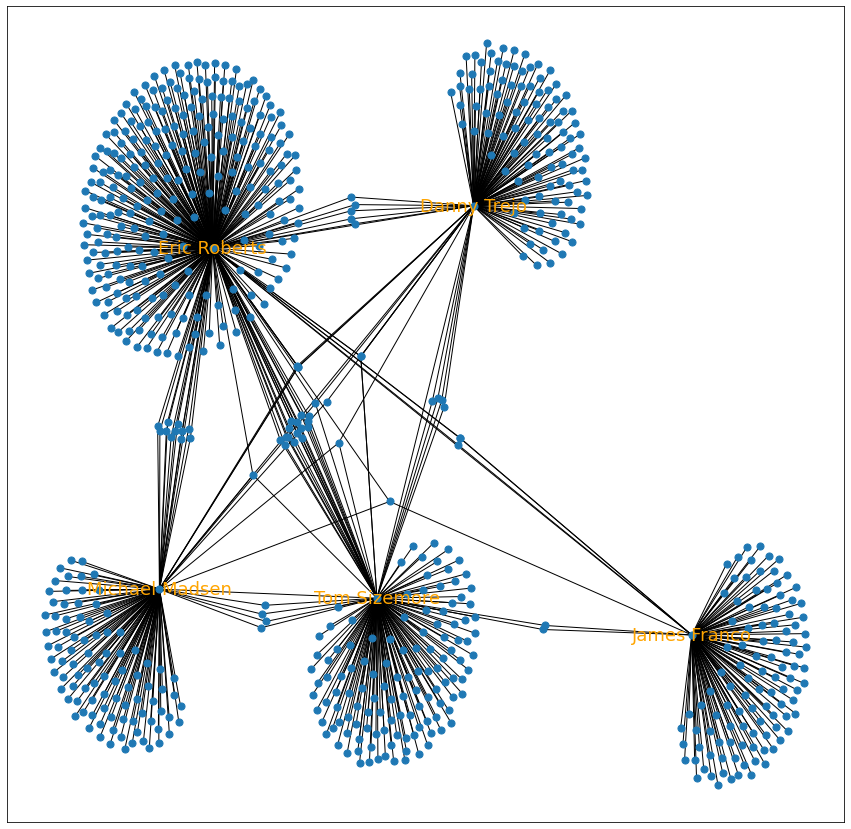

In [ ]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G_megamix, labels=labels, with_labels=True, node_size=50, font_size=18, font_color="orange")
plt.show()

In [ ]:
df_E = df[(df.actor1=="Eric Roberts")| (df.actor2=="Eric Roberts")]

In [ ]:
G_E = nx.from_pandas_edgelist(df_E, "actor1", "actor2", create_using=nx.Graph())

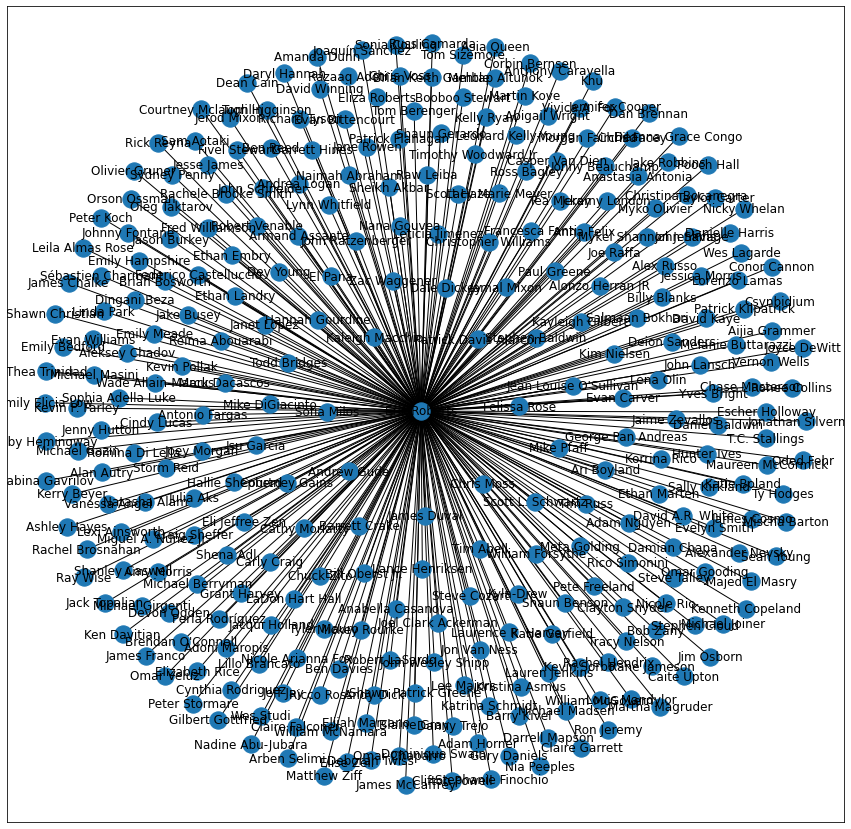

In [ ]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G_E)
plt.show()

In [ ]:
df2 = df.groupby(["actor1", "actor2"]).size().reset_index(name="NbrOfMovies")

In [ ]:
df2

,actor1,actor2,NbrOfMovies
0,'Crazy' John Brooks,Chipper 'Bro' Bell,1
1,'Crazy' John Brooks,Jo Cahow,1
2,'Crazy' John Brooks,Kevin 'Skippy Jammer' Givens,1
3,'Ganja' Karuppu,Arthana Binu,1
4,'Ganja' Karuppu,Gnanasambandam,1
...,...,...,...
180648,Zoltán Perjés,Zsolt Nagy,1
180649,Zuzana Bydzovská,Zuzana Fialová,1
180650,Zuzana Konecná,Zuzana Mauréry,1
180651,Álvaro Cervantes,Úrsula Corberó,1


In [ ]:
df3 = df2[df2.NbrOfMovies > 1]

In [ ]:
df3

,actor1,actor2,NbrOfMovies
75,A. Michelle Harleston,Everett Anderson,2
83,A. Michelle Harleston,Robert Parker IV,2
84,A. Michelle Harleston,Ronrico Albright,2
171,A.J. Germaine,Phillip Tolle,2
181,A.J. Khan,Darian Caine,2
...,...,...,...
180390,William Jase,Zhu. Bing,2
180598,Yui Ishikawa,Yû Kobayashi,2
180599,Yui Ishikawa,Yûki Kaji,2
180626,Yû Kobayashi,Yûki Kaji,2


In [ ]:
df = df3

#### Graph - removing based on df (removed actor pairs who only had one movie together)

In [ ]:
G = nx.from_pandas_edgelist(df, "actor1", "actor2", create_using=nx.Graph())

In [ ]:
print(nx.info(G)), nx.density(G), nx.degree(G)
# Number of nodes: 3369
# Number of edges: 3163
# Average degree: 1.8777

#### Reading in df_test.pkl

In [ ]:
df_test = pd.read_pickle("df_test")

In [ ]:
df_test2 = df_test.groupby(["actor1", "actor2"]).size().reset_index(name="NbrOfMovies")

In [ ]:
df_test2[df_test2.NbrOfMovies >1].sort_values("NbrOfMovies", ascending=False)

,actor1,actor2,NbrOfMovies
9532,Justin J. Wheeler,Paul 'Maxx' Rinehart,12
9535,Justin J. Wheeler,Toni Thompson,11
11963,Paul 'Maxx' Rinehart,Toni Thompson,11
7956,Jacob Whiteshed,Maria Petrano,7
2521,Ben Bostick,Toni Thompson,7
...,...,...,...
5230,David E. Cazares,Deanna Grace Congo,2
5352,Dawna Lee Heising,John Reign,2
5379,Dean Cain,Kathy Patterson,2
5388,Dean Cain,Timothy E. Goodwin,2


In [ ]:
df_test2[df_test2.NbrOfMovies >1].sort_values("NbrOfMovies", ascending=False)[:40]

,actor1,actor2,NbrOfMovies
9532,Justin J. Wheeler,Paul 'Maxx' Rinehart,12
9535,Justin J. Wheeler,Toni Thompson,11
11963,Paul 'Maxx' Rinehart,Toni Thompson,11
7956,Jacob Whiteshed,Maria Petrano,7
2521,Ben Bostick,Toni Thompson,7
10864,Maria Petrano,Thomas Freeley,6
5382,Dean Cain,Michael Sigler,5
7957,Jacob Whiteshed,Thomas Freeley,5
2519,Ben Bostick,Paul 'Maxx' Rinehart,5
12703,Shawn C. Phillips,Sheri Davis,5
